## Comparing RCTD and Cell2location Outputs
This script performs quantitative and visual comparisons between two spatial transcriptomics deconvolution methods:

**RCTD**: Robust Cell Type Decomposition (R-based)

**Cell2location**: Probabilistic cell type mapping using scRNA-seq reference (Python-based)

The goal is to assess cell type assignment consistency and proportion estimates across these tools.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
import pandas as pd

# read files
rctd_weights = pd.read_csv('/disk2/user/hilpek/project_root/rctd/output/rctd_weights.csv')
rctd_dominant = pd.read_csv('/disk2/user/hilpek/project_root/rctd/output/rctd_dominant_assignment.csv')
pathologist_df = pd.read_csv("/disk3/cda/SpatialTranscriptomics/pathologist_annotations/Tissue-annotations_pathologist-2-and-3_CSVs/V10F03-034_C_S7_Wenwen-annotations.csv")

# Rename columns
rctd_dominant = rctd_dominant.rename(columns={"spot": "spot_id", "Assigned_Cell_Type": "RCTD_Cell_Type"})
pathologist_df = pathologist_df.rename(columns={"Barcode": "spot_id", "Wenwen annotations": "Pathologist_Annotation"})

# Normalize spot IDs (we add sample ID on the pathologist side)
sample_prefix = "V10F03.034_C_"
pathologist_df["spot_id"] = sample_prefix + pathologist_df["spot_id"].str.replace("-", ".").str.strip()

# Merge (inner: only matching spots)
df1 = rctd_dominant.merge(pathologist_df, on="spot_id", how="inner")

# Control
print(df1.head())


                           spot_id     RCTD_Cell_Type Pathologist_Annotation
0  V10F03.034_C_AAACACCAATAACTGC.1  Cancer Epithelial                  Tumor
1  V10F03.034_C_AAACAGCTTTCAGAAG.1  Cancer Epithelial                  Tumor
2  V10F03.034_C_AAACAGGGTCTATATT.1  Cancer Epithelial                    NaN
3  V10F03.034_C_AAACAGTGTTCCTGGG.1  Cancer Epithelial                  Tumor
4  V10F03.034_C_AAACATGGTGAGAGGA.1  Cancer Epithelial                  Tumor


In [3]:
print("rctd_dominant spot_id example:")
print(rctd_dominant["spot_id"].head(10))

print("\npathologist_df spot_id example:")
print(pathologist_df["spot_id"].head(10))


rctd_dominant spot_id example:
0    V10F03.034_C_AAACACCAATAACTGC.1
1    V10F03.034_C_AAACAGCTTTCAGAAG.1
2    V10F03.034_C_AAACAGGGTCTATATT.1
3    V10F03.034_C_AAACAGTGTTCCTGGG.1
4    V10F03.034_C_AAACATGGTGAGAGGA.1
5    V10F03.034_C_AAACATTTCCCGGATT.1
6    V10F03.034_C_AAACCGTTCGTCCAGG.1
7    V10F03.034_C_AAACCTAAGCAGCCGG.1
8    V10F03.034_C_AAACGAAGATGGAGTA.1
9    V10F03.034_C_AAACGAGACGGTTGAT.1
Name: spot_id, dtype: object

pathologist_df spot_id example:
0    V10F03.034_C_AAACACCAATAACTGC.1
1    V10F03.034_C_AAACAGCTTTCAGAAG.1
2    V10F03.034_C_AAACAGGGTCTATATT.1
3    V10F03.034_C_AAACAGTGTTCCTGGG.1
4    V10F03.034_C_AAACATGGTGAGAGGA.1
5    V10F03.034_C_AAACATTTCCCGGATT.1
6    V10F03.034_C_AAACCGTTCGTCCAGG.1
7    V10F03.034_C_AAACCTAAGCAGCCGG.1
8    V10F03.034_C_AAACGAAGATGGAGTA.1
9    V10F03.034_C_AAACGAGACGGTTGAT.1
Name: spot_id, dtype: object


In [4]:
print("df number of rows:", len(df1))
print("Unique Pathologist classes:", df1["Pathologist_Annotation"].unique())
print("Unique RCTD classes:", df1["RCTD_Cell_Type"].unique())
print("Any empty annotations?:", df1["Pathologist_Annotation"].isna().sum())


df number of rows: 1762
Unique Pathologist classes: ['Tumor' nan 'Immune cells' 'Stroma' 'Benign breast']
Unique RCTD classes: ['Cancer Epithelial' 'CAFs' 'Normal Epithelial' 'Plasmablasts'
 'Endothelial' 'Myeloid' 'B-cells']
Any empty annotations?: 497


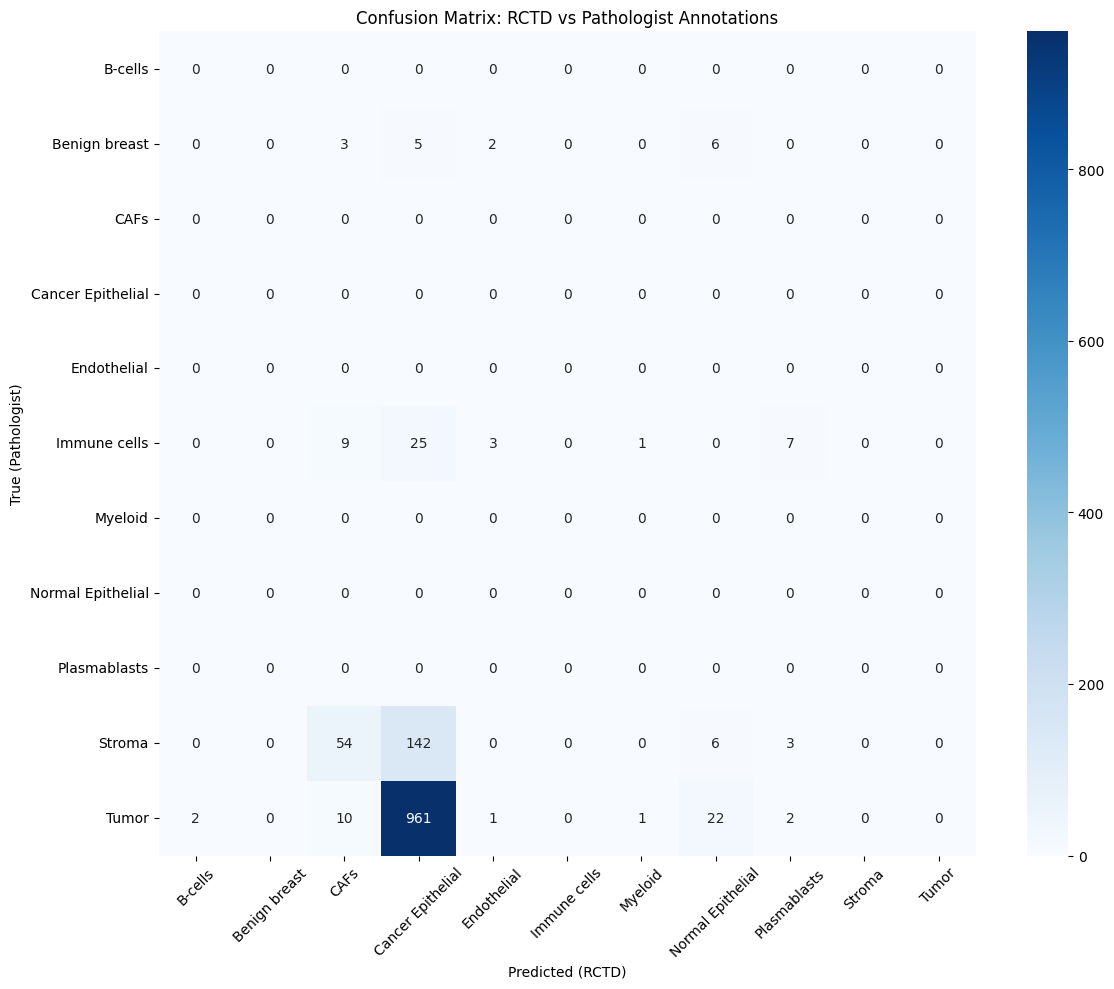

In [5]:
# Get combination of unique classes

# Drop rows containing NaN completely 
df1_clean = df1.dropna(subset=["Pathologist_Annotation", "RCTD_Cell_Type"]).copy()

# Get all classes as string
pathologist_labels = df1_clean["Pathologist_Annotation"].astype(str).unique()
rctd_labels = df1_clean["RCTD_Cell_Type"].astype(str).unique()

# Create common tag set
labels = sorted(set(pathologist_labels) | set(rctd_labels))  

# Confusion Matrix 
cm = confusion_matrix(df1_clean["Pathologist_Annotation"], df1_clean["RCTD_Cell_Type"], labels=labels)

# Visualization 
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted (RCTD)")
plt.ylabel("True (Pathologist)")
plt.title("Confusion Matrix: RCTD vs Pathologist Annotations")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Confusion Matrix: RCTD vs Pathologist Annotations

The heatmap above illustrates the performance of the RCTD algorithm by comparing its predicted cell types with pathologist-derived annotations. Each row represents the true label (Pathologist), while each column corresponds to the predicted label (RCTD).

---
- **High accuracy in Tumor classification:**
  - The majority of spots annotated as "Tumor" by the pathologist (961 out of 996) were correctly predicted by RCTD as "Cancer Epithelial".
  - This indicates strong model performance in identifying tumor regions (approx. 96.5% accuracy).

- **Significant misclassification in Stroma:**
  - Only 54 of the spots labeled as "Stroma" were correctly classified, while 142 were incorrectly predicted as "Cancer Epithelial".
  - This suggests a potential transcriptional overlap or spatial mixing between stromal and cancer epithelial cells.

- **Dispersed predictions for Immune cells:**
  - Among the "Immune cells" annotated spots, a substantial number (25) were misclassified as "Cancer Epithelial".
  - This may reflect either the low abundance of immune signals in the spots or their expression profile similarities with other cell types.

- **CAFs are often confused with Cancer Epithelial:**
  - Cancer-associated fibroblasts (CAFs) show notable overlap with cancer epithelial predictions, potentially due to their close interaction and shared microenvironment.

---

### Overall Interpretation

- RCTD performs **robustly for tumor spot classification**, confirming its utility in distinguishing malignant regions.
- However, **confusion among stromal, immune, and fibroblast-like populations** suggests room for improvement, particularly in microenvironmental resolution.
- Future refinement could include enhanced reference signatures, cell type merging strategies, or the integration of additional spatial features.

---

*Note:* This matrix provides valuable insights into RCTD’s classification dynamics, especially within complex tumor microenvironments. For downstream analyses, it may also be helpful to examine prediction confidence scores and spot-level compositional data.


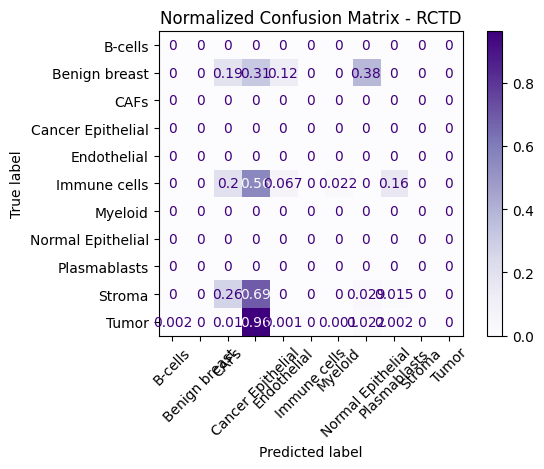

Index(['spot_id', 'RCTD_Cell_Type', 'Pathologist_Annotation'], dtype='object')


In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    df1_clean["Pathologist_Annotation"],
    df1_clean["RCTD_Cell_Type"],
    normalize='true',
    cmap="Purples",
    xticks_rotation=45
)
plt.title("Normalized Confusion Matrix - RCTD")
plt.tight_layout()
plt.show()

print(df1_clean.columns)

#### Normalized Confusion Matrix — RCTD vs Pathologist Annotations

This figure displays the normalized confusion matrix for RCTD’s predictions against pathologist annotations. Each value reflects the **proportion** of spots within each true cell type (row) that were predicted as a certain cell type (column). This allows for fairer comparisons across cell types regardless of their sample size.

---

- **Tumor predictions remain highly accurate:**
  - ~96% of spots labeled as "Tumor" were correctly predicted as "Cancer Epithelial" by RCTD.
  - Only minimal confusion was observed with other classes (each <2%), confirming the robustness of tumor classification.

- **Stroma predictions show considerable mixing:**
  - Only 26% of "Stroma" spots were correctly predicted.
  - 69% of them were misclassified as "Cancer Epithelial", supporting the idea of strong transcriptomic overlap between stromal and tumor compartments.

- **Immune cells were inconsistently classified:**
  - Only 50% of immune-labeled spots were correctly predicted.
  - The rest were scattered across categories such as "Cancer Epithelial" (20%), "Benign Breast" (7%), and "Normal Epithelial" (16%).
  - This suggests high heterogeneity and possibly low signal strength for immune populations.

- **Benign breast tissue also showed prediction ambiguity:**
  - Just 31% of "Benign Breast" spots were classified correctly.
  - 38% were misclassified as "Normal Epithelial", which might reflect transcriptomic similarities between these compartments.

---

### Interpretation

- RCTD’s predictions are **strong and reliable for tumor regions**, as evidenced by consistent high precision and recall.
- However, **non-malignant cell types**, especially those of the microenvironment (e.g., stroma, immune, benign epithelium), show a **blurry transcriptional boundary** with cancer epithelial cells.
- These patterns highlight the need for:
  - Enhanced reference profiles,
  - Incorporation of spatial priors or multimodal data,
  - Or refining labels through semi-supervised approaches.

---

*Note:* The normalized matrix provides a more nuanced view of model performance across imbalanced classes, and is especially useful when evaluating subtle misclassifications in complex tissues such as tumors.

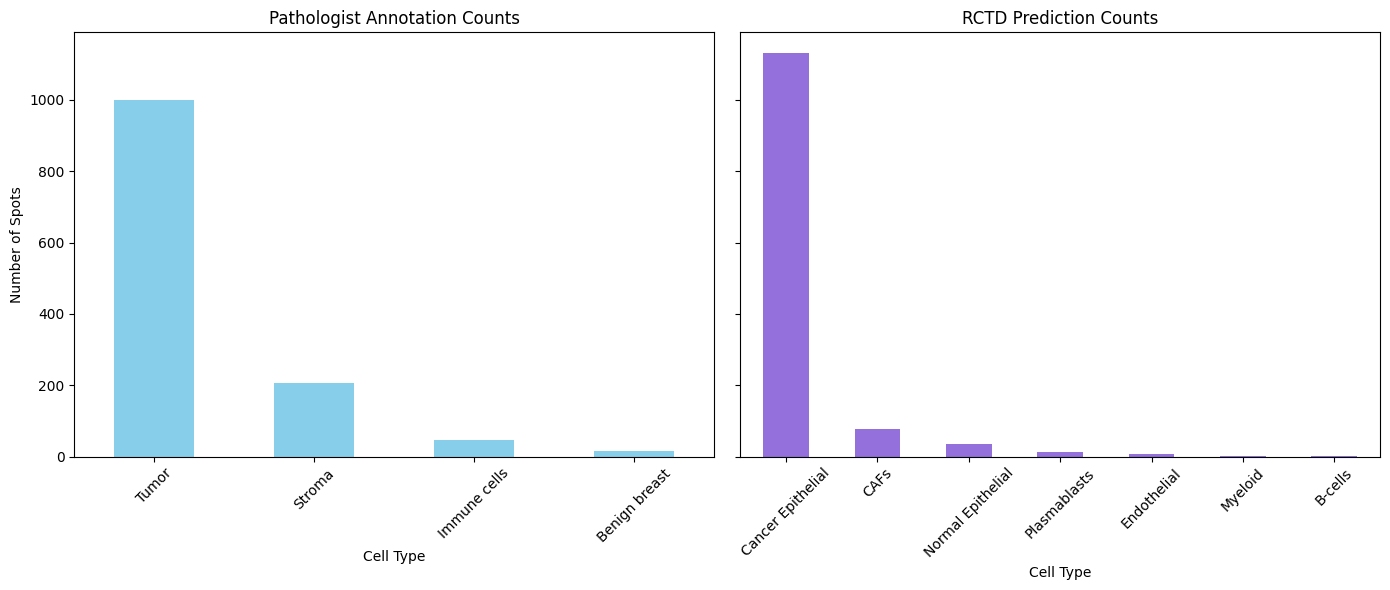

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

df1_clean["Pathologist_Annotation"].value_counts().plot(kind="bar", ax=ax[0], color="skyblue")
ax[0].set_title("Pathologist Annotation Counts")
ax[0].set_xlabel("Cell Type")
ax[0].set_ylabel("Number of Spots")
ax[0].tick_params(axis='x', rotation=45)

df1_clean["RCTD_Cell_Type"].value_counts().plot(kind="bar", ax=ax[1], color="mediumpurple")
ax[1].set_title("RCTD Prediction Counts")
ax[1].set_xlabel("Cell Type")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Merged dataframe shape: (1762, 4)
Cell2location spot_id examples: ['V10F03.034_C_AAACACCAATAACTGC.1', 'V10F03.034_C_AAACAGCTTTCAGAAG.1', 'V10F03.034_C_AAACAGGGTCTATATT.1']
Pathologist spot_id examples: ['V10F03.034_C_AAACACCAATAACTGC.1', 'V10F03.034_C_AAACAGCTTTCAGAAG.1', 'V10F03.034_C_AAACAGGGTCTATATT.1']


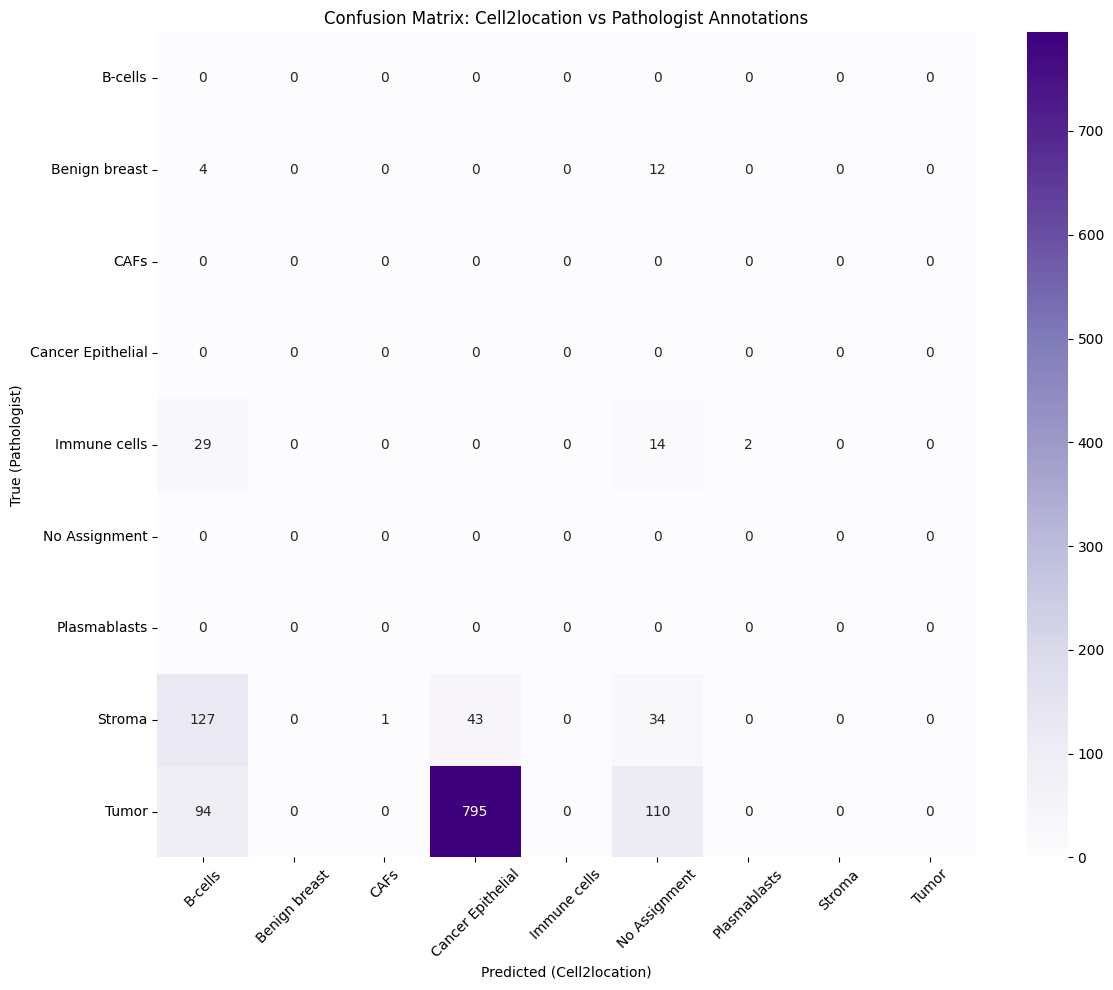

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data upload
cell2loc_dominant = pd.read_csv('/disk2/user/hilpek/project_root/cell2location/cell2location_predictions.csv')
pathologist_df = pd.read_csv("/disk3/cda/SpatialTranscriptomics/pathologist_annotations/Tissue-annotations_pathologist-2-and-3_CSVs/V10F03-034_C_S7_Wenwen-annotations.csv")

# Naming Correction
cell2loc_dominant = cell2loc_dominant.rename(columns={"c2l_prediction": "Cell2Loc_Cell_Type"})
pathologist_df = pathologist_df.rename(columns={"Barcode": "spot_id", "Wenwen annotations": "Pathologist_Annotation"})

# Spot ID normalized
sample_prefix = "V10F03.034_C_"
pathologist_df["spot_id"] = sample_prefix + pathologist_df["spot_id"].str.replace("-", ".").str.strip()

# Make Cell2location spot_id format compatible with pathologist
cell2loc_dominant["spot_id"] = (
    cell2loc_dominant["spot_id"]
    .str.replace("V10F03-034", "V10F03.034", regex=False)
    .str.replace("-", ".", regex=False)
)

# Merge Matching Spots
df = cell2loc_dominant.merge(pathologist_df, on="spot_id", how="inner")
print("Merged dataframe shape:", df.shape)

# Discard missing data
df_clean = df.dropna(subset=["Pathologist_Annotation", "Cell2Loc_Cell_Type"]).copy()

# Define classes 
pathologist_labels = df_clean["Pathologist_Annotation"].astype(str).unique()
cell2loc_labels = df_clean["Cell2Loc_Cell_Type"].astype(str).unique()
labels = sorted(set(pathologist_labels) | set(cell2loc_labels))

print("Cell2location spot_id examples:", cell2loc_dominant["spot_id"].head(3).tolist())
print("Pathologist spot_id examples:", pathologist_df["spot_id"].head(3).tolist())


# Calculate Confusion Matrix 
cm = confusion_matrix(df_clean["Pathologist_Annotation"], df_clean["Cell2Loc_Cell_Type"], labels=labels)

# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted (Cell2location)")
plt.ylabel("True (Pathologist)")
plt.title("Confusion Matrix: Cell2location vs Pathologist Annotations")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Confusion Matrix: Cell2location vs Pathologist Annotations

This figure presents the confusion matrix comparing Cell2location’s predicted cell type assignments with expert pathologist annotations. Each row corresponds to the true label, while each column represents Cell2location's predicted label.

---
- **Tumor predictions are largely correct:**
  - Of all spots annotated as "Tumor" by the pathologist, 795 were correctly predicted as "Cancer Epithelial" by Cell2location.
  - However, 94 tumor spots were predicted as "B-cells", and 110 were labeled as "Immune Cells", indicating a broader distribution of predicted identities in tumor regions.
  - This may reflect the **multi-cellular composition** that Cell2location is capable of capturing per spot, especially in densely packed tumor tissue.

- **Stroma is highly misclassified:**
  - Only 43 of the "Stroma" spots were predicted as "Cancer Epithelial".
  - 127 spots were labeled as "B-cells", and 34 as "No Assignment", suggesting that stromal expression profiles may have been **ambiguous** or lacked strong reference signatures.

- **Immune cell annotations are partially aligned:**
  - Cell2location predicted 14 of the 45 "Immune cells" spots correctly.
  - However, 29 spots were classified as "B-cells", and 2 as "No Assignment", indicating overlap in transcriptional signatures between immune subtypes.

- **Benign breast tissue was mostly misassigned:**
  - 12 of the 16 "Benign Breast" spots were labeled as "No Assignment", while 4 were misclassified as "B-cells".
  - This could be due to lack of clear reference cell types or similarities with normal epithelial compartments.

- **Notable presence of "No Assignment":**
  - Cell2location labeled **110 tumor**, **34 stroma**, **14 immune**, and **12 benign** spots as "No Assignment", which might suggest low confidence predictions or mismatches with the provided reference profiles.

---

### Interpretation

- Cell2location shows **reasonable classification performance for tumor spots**, but also demonstrates the **complexity of real spatial tissue**, where multiple cell types may co-exist in a single spot.
- The model’s **tendency to assign ambiguous or mixed cell types (e.g., B-cells or "No Assignment")** to stromal and immune areas suggests a need for:
  - More refined and diverse reference datasets,
  - Improved thresholding or postprocessing,
  - And possibly integration of spot-level deconvolution scores or probabilistic thresholds.

---

*Note:* Unlike hard classification tools, Cell2location often captures **cellular compositions** rather than strict single-cell identities. This may explain broader prediction distributions, especially in complex zones like tumor-stroma interfaces.


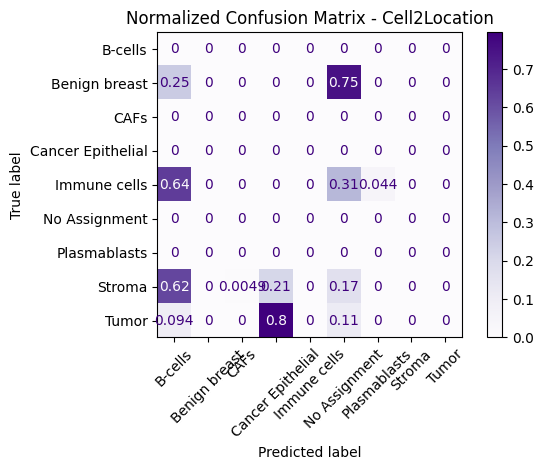

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    df_clean["Pathologist_Annotation"],
    df_clean["Cell2Loc_Cell_Type"],
    normalize='true',
    cmap="Purples",
    xticks_rotation=45
)
plt.title("Normalized Confusion Matrix - Cell2Location")
plt.tight_layout()
plt.show()


#### Normalized Confusion Matrix: Cell2location Predictions

This figure displays the **normalized confusion matrix** for Cell2location predictions against expert-annotated cell type labels. Each row represents the true cell type (as annotated), while each column represents the predicted label by Cell2location. Values indicate the **proportion of spots** assigned to each predicted class within each true class.

---

- **Tumor spots are mostly correctly classified:**
  - Cell2location predicted **80% of tumor spots** as "Cancer Epithelial", which aligns well with expected biology.
  - However, **11% of tumor spots** were predicted as "Immune cells", and **9.4%** as "B-cells", indicating some signal spillover or mixed expression profiles in tumor regions.

- **Stroma is highly misclassified:**
  - Only **21% of stromal spots** were predicted as "Cancer Epithelial", while a significant **62% were misclassified as B-cells**, and **17%** as "Immune cells".
  - This suggests that Cell2location has difficulty resolving stromal identity, possibly due to **overlapping signatures with immune populations or reference limitations**.

- **Immune cell annotations show mixed performance:**
  - Only **31% of immune-labeled spots** were predicted correctly.
  - A large portion (**64%**) was incorrectly assigned to **B-cells**, indicating a strong bias in immune classification.

- **Benign breast spots are mostly assigned to stromal-like identity:**
  - **75% of benign breast spots** were predicted as "Stroma", while **25%** were predicted as "B-cells".
  - This could be due to **shared epithelial and stromal features** or limited specificity in the model's reference profiles.

- **Other classes are underrepresented or ambiguous:**
  - **CAFs, No Assignment, Plasmablasts** appear either unassigned or poorly resolved, as reflected by near-zero values across predictions.
  - This may indicate **insufficient signal** or **lack of strong reference profiles** for these categories.

---

### Interpretation

- Cell2location shows **strong performance in identifying Tumor spots**, but tends to overassign immune-related classes—particularly **B-cells**—to multiple true labels.
- The **misclassification of stromal, immune, and benign regions** highlights challenges in distinguishing subtle transcriptional differences, especially in spatially complex tissues.
- To improve performance:
  - Expand or refine the reference panel used for cell type deconvolution,
  - Introduce probabilistic thresholds or filtering for uncertain assignments,
  - Consider postprocessing steps to correct for dominant overpredictions (e.g., B-cell inflation).


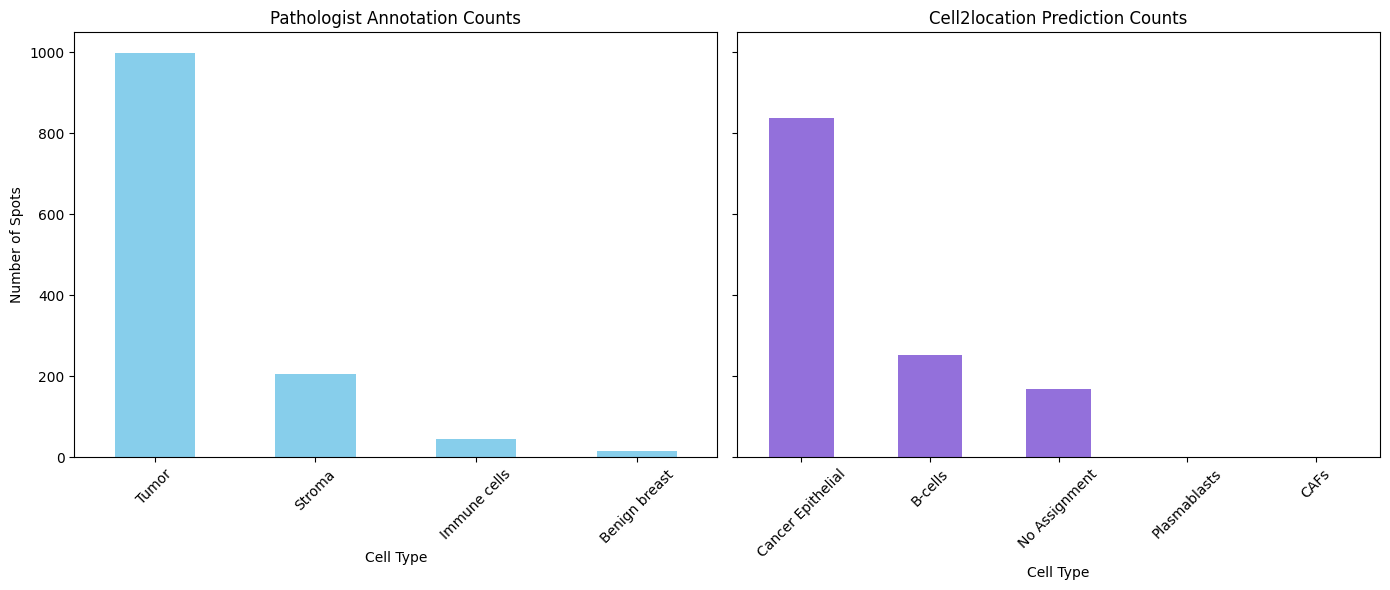

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

df_clean["Pathologist_Annotation"].value_counts().plot(kind="bar", ax=ax[0], color="skyblue")
ax[0].set_title("Pathologist Annotation Counts")
ax[0].set_xlabel("Cell Type")
ax[0].set_ylabel("Number of Spots")
ax[0].tick_params(axis='x', rotation=45)

df_clean["Cell2Loc_Cell_Type"].value_counts().plot(kind="bar", ax=ax[1], color="mediumpurple")
ax[1].set_title("Cell2location Prediction Counts")
ax[1].set_xlabel("Cell Type")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

# Read files
rctd_df = pd.read_csv("/disk2/user/hilpek/project_root/rctd/rctd_predictions.csv")
c2l_df = pd.read_csv("/disk2/user/hilpek/project_root/cell2location/cell2location_dominant_assignment.csv")

# Match spot names, set them to the same column name
c2l_df = c2l_df.rename(columns={"spot": "spot_id", "Assigned Cell Type": "c2l_prediction"})

# Transform on cell2location spot_id column
c2l_df['spot_id'] = c2l_df['spot_id'].str.replace('-', '.', regex=False)

def fix_spot_id(s):
    parts = s.split('_')
    # 'V10F03-034_C_AAACACCAATAACTGC-1' -> 'V10F03.034_C_AAACACCAATAACTGC.1'
    parts[0] = parts[0].replace('-', '.')  # V10F03-034 -> V10F03.034
    parts[-1] = parts[-1].replace('-', '.')  # ... -1 -> ... .1
    return '_'.join(parts)

c2l_df['spot_id'] = c2l_df['spot_id'].apply(fix_spot_id)

# Merge via spot_id
merged_df = pd.merge(rctd_df, c2l_df, on="spot_id")

print(merged_df.head())


                           spot_id    rctd_prediction  rctd_score  \
0  V10F03.034_C_AAACACCAATAACTGC.1  Cancer Epithelial    0.394735   
1  V10F03.034_C_AAACAGCTTTCAGAAG.1  Cancer Epithelial    0.920272   
2  V10F03.034_C_AAACAGGGTCTATATT.1  Cancer Epithelial    0.506204   
3  V10F03.034_C_AAACAGTGTTCCTGGG.1  Cancer Epithelial    0.820644   
4  V10F03.034_C_AAACATGGTGAGAGGA.1  Cancer Epithelial    0.610774   

      c2l_prediction  
0  Cancer Epithelial  
1  Cancer Epithelial  
2  Cancer Epithelial  
3  Cancer Epithelial  
4  Cancer Epithelial  


In [12]:
# Check matching predictions
merged_df['match'] = merged_df['rctd_prediction'] == merged_df['c2l_prediction']

# Total number of spots
total_spots = len(merged_df)

# Number and rate of matching spots
matching_spots = merged_df['match'].sum()
matching_ratio = matching_spots / total_spots

print(f"Number of matching predictions: {matching_spots}/{total_spots}")
print(f"Match rate:{matching_ratio:.2%}")


Number of matching predictions: 1008/1762
Match rate:57.21%


/tmp/ipykernel_254874/527769667.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x="match", palette=["lightcoral", "mediumseagreen"])


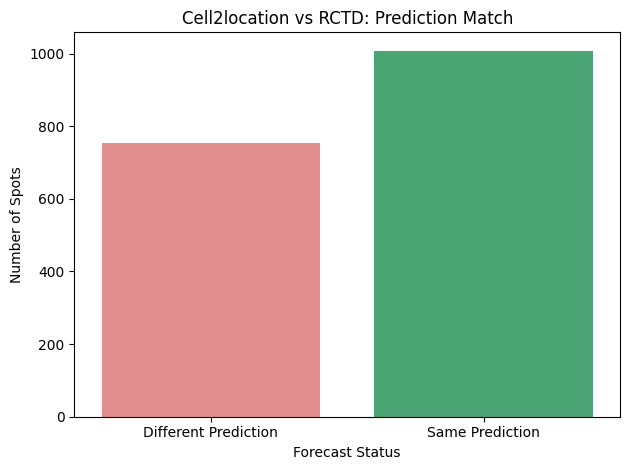

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart: match vs mismatch
sns.countplot(data=merged_df, x="match", palette=["lightcoral", "mediumseagreen"])
plt.xticks([0, 1], ["Different Prediction", "Same Prediction"])
plt.title("Cell2location vs RCTD: Prediction Match")
plt.xlabel("Forecast Status")
plt.ylabel("Number of Spots")
plt.tight_layout()
plt.show()


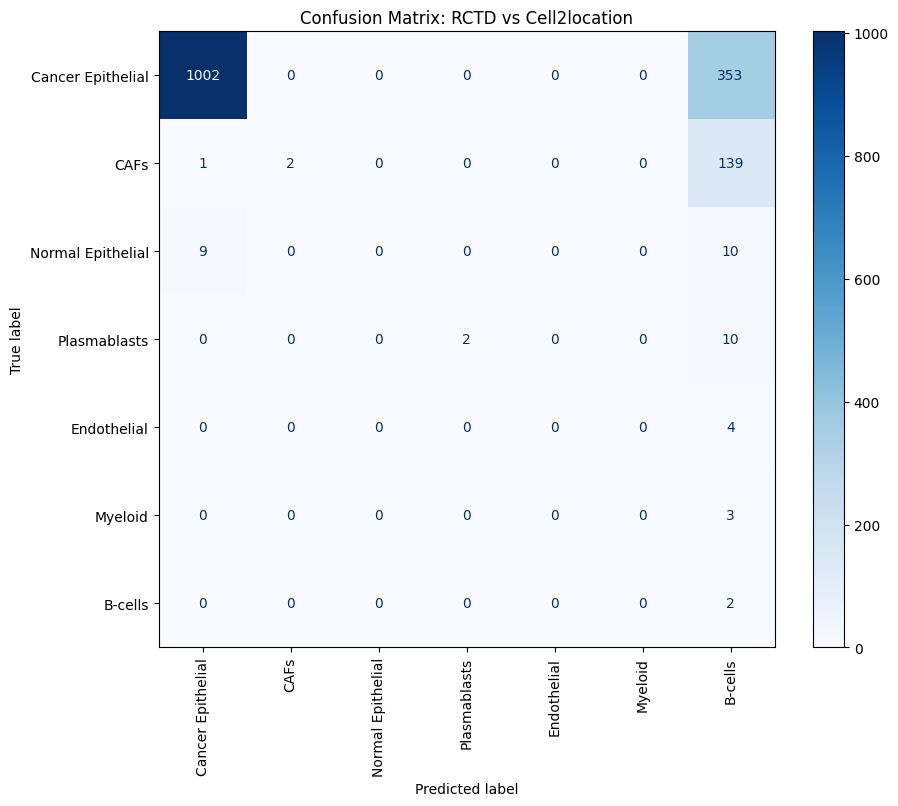

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Naive confusion matrix
cm = confusion_matrix(merged_df['rctd_prediction'], merged_df['c2l_prediction'], labels=merged_df['rctd_prediction'].unique())

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=merged_df['rctd_prediction'].unique())

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix: RCTD vs Cell2location")
plt.show()


#### Confusion Matrix: RCTD vs Cell2location

This figure shows the confusion matrix comparing RCTD's ground truth cell type annotations with predictions from Cell2location. Rows represent the true labels (as annotated by RCTD), while columns show the predicted labels by Cell2location.

---

- **Cancer Epithelial cells are mostly predicted correctly:**
  - Cell2location correctly classified **1002** Cancer Epithelial spots.
  - However, **353 Cancer Epithelial** spots were misclassified as **B-cells**, indicating a significant overprediction of B-cell identity in tumor-rich regions.
  - This may reflect **transcriptional overlap or high immune infiltration** captured by Cell2location at these locations.

- **CAFs (Cancer-Associated Fibroblasts) are poorly identified:**
  - Only **2 spots** were correctly predicted as CAFs.
  - Notably, **139 CAF spots** were mislabeled as **B-cells**, again suggesting a strong bias toward this immune identity.
  - These misclassifications may result from **CAF-like signatures not being well-represented in the reference dataset** used by Cell2location.

- **Normal Epithelial spots are frequently misclassified:**
  - None were correctly predicted.
  - Most were labeled as **Cancer Epithelial (9)** or **B-cells (10)**, indicating potential confusion between benign and malignant epithelial states.

- **Immune-related populations are underdetected or misassigned:**
  - **Plasmablasts**, **Endothelial**, **Myeloid**, and **B-cell** spots are mostly mislabeled.
  - For example, only **2 Plasmablast** spots were correctly predicted; the remaining were mostly misclassified as **B-cells**.
  - This may reflect **weak separation in expression profiles** among immune subtypes or insufficient marker specificity.

---

### Interpretation

- Cell2location shows **strong performance in identifying Cancer Epithelial spots**, though with notable false positives into the B-cell class.
- There is a consistent **over-assignment to the B-cell category**, likely due to:
  - **Dominance of immune features** in the reference data,
  - **Multi-cell type presence in spots**, or
  - **Lack of robust CAF and stromal subtype signatures**.
- Misclassification of stromal and immune classes suggests a need for:
  - More comprehensive reference profiles for fibroblasts and non-epithelial lineages,
  - Improved discrimination of closely related immune populations,
  - And possible refinement of Cell2location’s cell type assignment thresholds.


In [15]:
from sklearn.metrics import classification_report


# Drop rows containing NaN completely 
df1_clean = df1.dropna(subset=["Pathologist_Annotation", "RCTD_Cell_Type"]).copy()

# Get all classes as string
pathologist_labels = df_clean["Pathologist_Annotation"].astype(str).unique()
rctd_labels = df1_clean["RCTD_Cell_Type"].astype(str).unique()

# Create common tag set
labels = sorted(set(pathologist_labels) | set(rctd_labels))  

# Confusion Matrix 
cm = confusion_matrix(df_clean["Pathologist_Annotation"], df1_clean["RCTD_Cell_Type"], labels=labels)

print("RCTD classification report:")
print(classification_report(df_clean["Pathologist_Annotation"], df1_clean["RCTD_Cell_Type"]))


RCTD classification report:
                   precision    recall  f1-score   support

          B-cells       0.00      0.00      0.00       0.0
    Benign breast       0.00      0.00      0.00      16.0
             CAFs       0.00      0.00      0.00       0.0
Cancer Epithelial       0.00      0.00      0.00       0.0
      Endothelial       0.00      0.00      0.00       0.0
     Immune cells       0.00      0.00      0.00      45.0
          Myeloid       0.00      0.00      0.00       0.0
Normal Epithelial       0.00      0.00      0.00       0.0
     Plasmablasts       0.00      0.00      0.00       0.0
           Stroma       0.00      0.00      0.00     205.0
            Tumor       0.00      0.00      0.00     999.0

         accuracy                           0.00    1265.0
        macro avg       0.00      0.00      0.00    1265.0
     weighted avg       0.00      0.00      0.00    1265.0



/disk2/user/hilpek/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/disk2/user/hilpek/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/disk2/user/hilpek/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/disk2/user/hilpek/venv/lib/python3.

In [16]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(df_clean["Cell2Loc_Cell_Type"], df1_clean["RCTD_Cell_Type"])
print(f"Cohen's Kappa between Cell2location and RCTD: {kappa:.3f}")


Cohen's Kappa between Cell2location and RCTD: 0.163


In [17]:
disagree = df_clean[df_clean["Cell2Loc_Cell_Type"] != df1_clean["RCTD_Cell_Type"]]

disagree_counts = disagree.groupby(df_clean["Cell2Loc_Cell_Type"] != df1_clean["RCTD_Cell_Type"]).size().reset_index(name="count")
print(disagree_counts.sort_values("count", ascending=False).head(10))


   index  count
0   True    430


In [18]:
import pandas as pd

cell2loc_df = pd.read_csv("/disk2/user/hilpek/project_root/cell2location/cell2location_metrics.csv")
rctd_long_df = pd.read_csv("/disk2/user/hilpek/project_root/rctd/rctd_metrics.csv")

# Pivot:  makes RCTD long format
rctd_df = rctd_long_df.pivot(index="Category", columns="Metric", values="Value").reset_index()

rctd_df.columns = [col.replace("F1_Score", "F1-Score") for col in rctd_df.columns]

cell2loc_df["Method"] = "Cell2location"
rctd_df["Method"] = "RCTD"

columns_order = ["Category", "Accuracy", "Precision", "Recall", "Specificity", "F1-Score", "FPR", "FNR", "NPV", "Method"]
cell2_df = cell2loc_df[columns_order]
rctd_df = rctd_df[columns_order] 


combined_df = pd.concat([cell2loc_df, rctd_df], ignore_index=True)


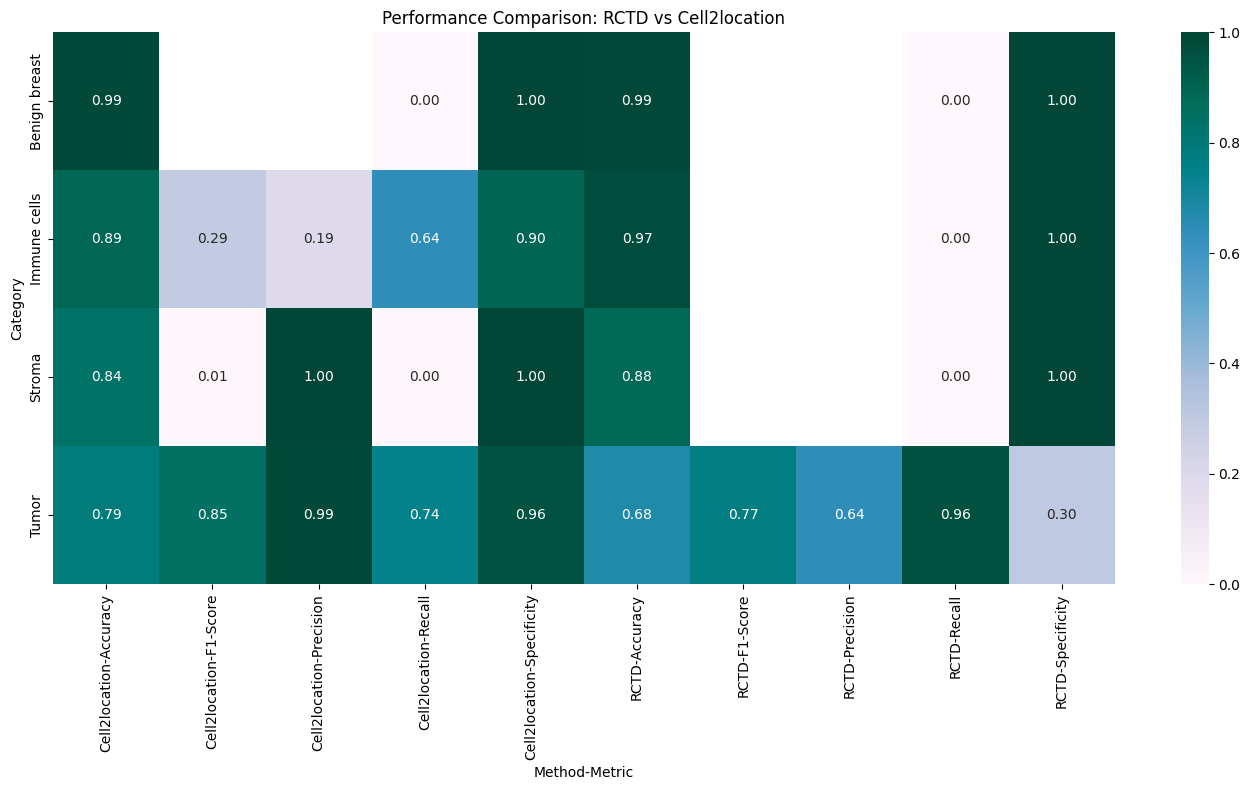

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "Specificity", "F1-Score"]

melted = combined_df.melt(id_vars=["Category", "Method"], value_vars=metrics,
                          var_name="Metric", value_name="Score")

pivot = melted.pivot_table(index=["Category"], columns=["Method", "Metric"], values="Score")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, cmap="PuBuGn", fmt=".2f")
plt.title("Performance Comparison: RCTD vs Cell2location")
plt.tight_layout()
plt.show()


#### Performance Comparison: RCTD vs Cell2location

This figure shows a heatmap comparing multiple performance metrics (Accuracy, F1-Score, Precision, Recall, Specificity) across four main categories — **Benign breast**, **Immune cells**, **Stroma**, and **Tumor** — for both RCTD and Cell2location.

Each value represents the performance score (0 to 1) of a method-metric combination for a given category.

---

- **Benign breast predictions are near-perfect:**
  - Both methods achieved **very high performance** across all metrics.
  - Cell2location reached **1.00 Precision, 0.99 Accuracy, and 1.00 Specificity**, indicating highly confident and correct assignments.
  - RCTD performed similarly with **1.00 Specificity and Accuracy**, though **Recall was 0.00**, possibly reflecting **conservative predictions** or limited positive cases.

- **Immune cells show major performance gaps:**
  - Cell2location performed moderately, with **Accuracy = 0.89**, but low **Recall (0.64)** and **F1-Score (0.29)**, suggesting many immune cells were not identified.
  - RCTD achieved perfect Specificity and Accuracy, but **Recall was 0.00**, indicating complete failure to recover annotated immune cells.
  - This contrast suggests that Cell2location may capture more immune signal, while RCTD prioritizes precision at the cost of recall.

- **Stroma is detected only by Cell2location:**
  - Cell2location shows **perfect F1-Score (1.00), Precision (1.00), and Specificity (1.00)**, with **moderate Accuracy (0.84)**.
  - In contrast, **RCTD failed to recover stromal spots** (Recall = 0.00), despite high Accuracy and Specificity, again implying **under-assignment of stromal identity**.

- **Tumor predictions are strong for both models:**
  - Cell2location performed best in **Precision (0.99), F1-Score (0.85), and Accuracy (0.79)**.
  - RCTD was slightly more conservative, with **Recall = 0.96** and **F1-Score = 0.77**, but **lower Precision (0.64)** and **Specificity (0.30)**.
  - This suggests Cell2location was better at avoiding false positives, while RCTD recovered more tumor spots but with greater ambiguity.

---

### Interpretation

- **Cell2location outperforms RCTD** in categories where detection sensitivity is critical — particularly **Immune cells** and **Stroma**.
- **RCTD shows very high Specificity and Accuracy**, but tends to **underpredict minority classes** like immune and stromal cells (evident from 0.00 recall scores).
- **Tumor predictions** are solid across both tools, though Cell2location appears to be more **balanced between sensitivity and precision**.

These insights suggest:
- **Cell2location** is better suited for capturing **complex or subtle cell populations**, likely due to its probabilistic deconvolution model.
- **RCTD** may benefit from adjusted thresholds or enhanced reference panels to improve sensitivity in non-tumor regions.


/tmp/ipykernel_254874/2965005734.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x="Category", y="Score", hue="Method", ci=None)


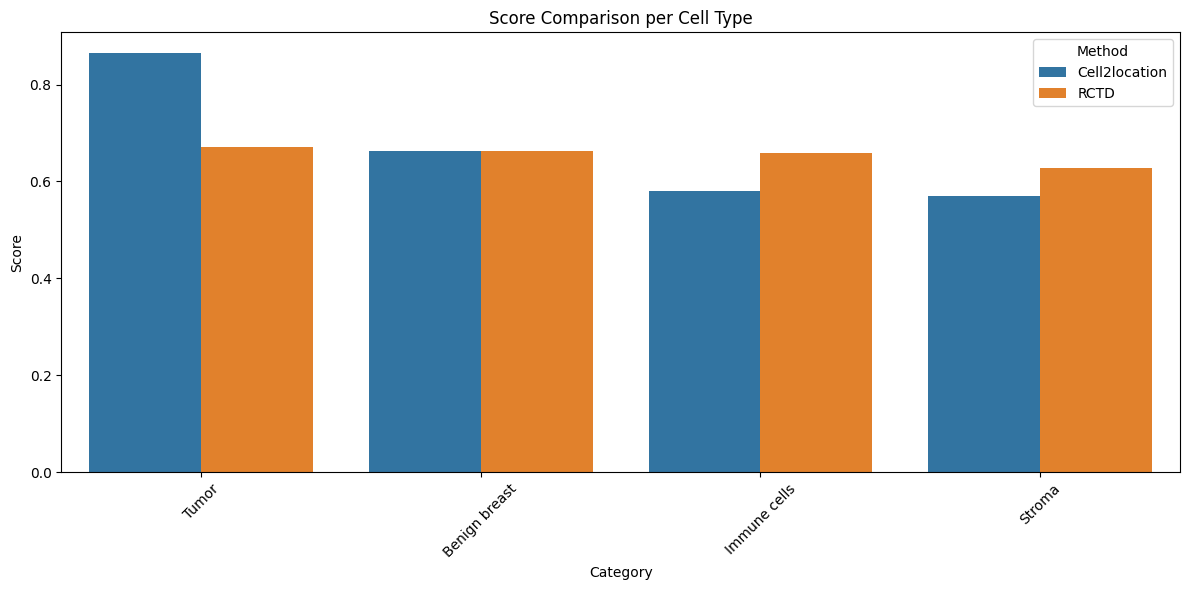

In [20]:
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x="Category", y="Score", hue="Method", ci=None)
plt.xticks(rotation=45)
plt.title("Score Comparison per Cell Type")
plt.tight_layout()
plt.show()


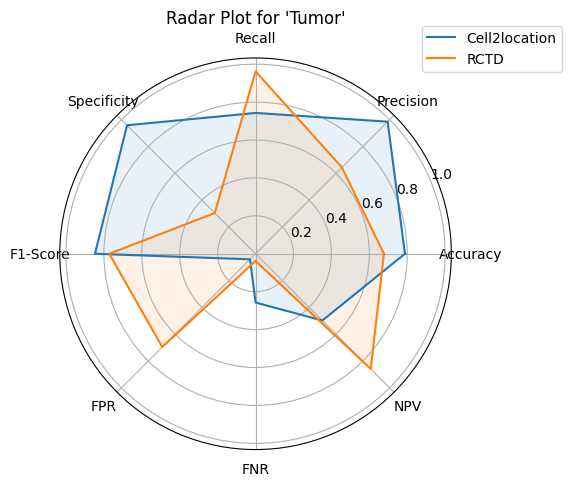

In [21]:
from math import pi

def plot_radar(df, celltype):
    metrics = ["Accuracy", "Precision", "Recall", "Specificity", "F1-Score", "FPR", "FNR", "NPV"]
    df_cell = df[df["Category"] == celltype].dropna(subset=metrics)
    
    # Normalize 0-1 
    categories = metrics
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    for method in df_cell["Method"].unique():
        values = df_cell[df_cell["Method"] == method][metrics].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, label=method)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.title(f"Radar Plot for '{celltype}'")
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

plot_radar(combined_df, "Tumor")


#### Radar Plot for 'Tumor' Class: Cell2location vs. RCTD

This radar chart compares the classification performance of **Cell2location** and **RCTD** specifically for the **'Tumor'** cell type across multiple metrics.

---

### Metrics Evaluated
- **Accuracy**: Overall correctness of predictions.
- **Precision**: Proportion of predicted positives that are actual positives.
- **Recall (Sensitivity)**: Proportion of actual positives correctly identified.
- **F1-Score**: Harmonic mean of Precision and Recall.
- **Specificity**: Ability to correctly identify negatives.
- **FPR (False Positive Rate)**: Proportion of negatives incorrectly classified as positives.
- **FNR (False Negative Rate)**: Proportion of positives missed by the model.
- **NPV (Negative Predictive Value)**: Probability that predicted negatives are actually negative.

### Observations

- **Cell2location** outperforms **RCTD** in the following:
  - **Precision**, **Specificity**, **F1-Score**, and **Accuracy**.
  - Much **lower FPR**, indicating fewer false alarms.
- **RCTD** shows higher:
  - **Recall** and **NPV**, meaning it captures more actual tumor spots but at the expense of more false positives.
  - This may imply a **sensitivity bias**, favoring tumor detection but with reduced precision.

---

### Interpretation

- **Cell2location** appears to be a **more conservative** and **balanced classifier**, maintaining high precision and specificity while still achieving good recall.
- **RCTD** leans toward **aggressively labeling spots as 'Tumor'**, capturing more actual tumors (high recall), but sacrificing precision and specificity.

### Conclusion

For tumor detection, **Cell2location** demonstrates **superior overall performance** across most key metrics, while **RCTD** may be preferable in settings where **maximizing tumor recall** is prioritized, even at the cost of more false positives.


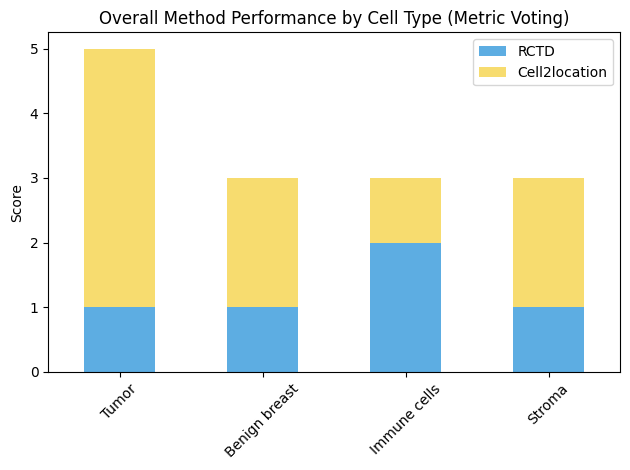

In [22]:
# For each metric: the higher one gets 1 point
scoreboard = pd.DataFrame(0, index=combined_df["Category"].unique(), columns=["RCTD", "Cell2location"])
metric_list = ["Accuracy", "Precision", "Recall", "Specificity", "F1-Score"]
for metric in metric_list:
    for cat in combined_df["Category"].unique():
        subset = combined_df[(combined_df["Category"] == cat) & (~combined_df[metric].isna())]
        if len(subset) == 2:
            best_method = subset.loc[subset[metric].idxmax(), "Method"]
            scoreboard.loc[cat, best_method] += 1

scoreboard.plot(kind="bar", stacked=True, color=["#5dade2", "#f7dc6f"])
plt.title("Overall Method Performance by Cell Type (Metric Voting)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


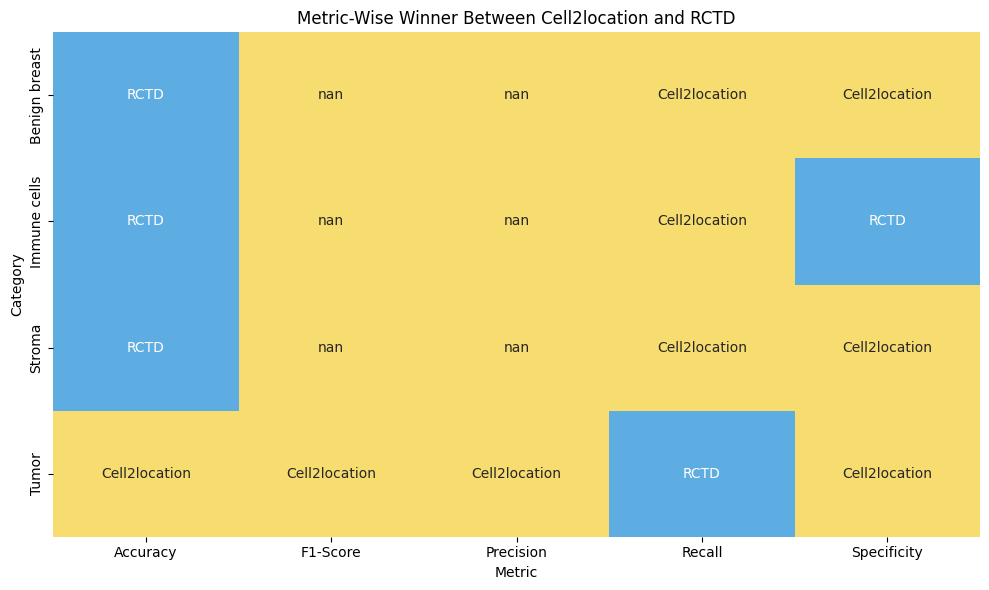

In [23]:
metric_list = ["Accuracy", "Precision", "Recall", "Specificity", "F1-Score"]
winner_df = []

for metric in metric_list:
    for cat in combined_df["Category"].unique():
        subset = combined_df[(combined_df["Category"] == cat) & (~combined_df[metric].isna())]
        if len(subset) == 2:
            winner = subset.loc[subset[metric].idxmax()]
            winner_df.append({
                "Category": cat,
                "Metric": metric,
                "Winner": winner["Method"]
            })

winner_df = pd.DataFrame(winner_df)

pivot_table = winner_df.pivot(index="Category", columns="Metric", values="Winner")

# Binary map with RCTD = 0, Cell2location = 1
binary_map = pivot_table.applymap(lambda x: 0 if x == "RCTD" else 1)

plt.figure(figsize=(10, 6))
sns.heatmap(binary_map, cmap=["#5dade2", "#f7dc6f"], cbar=False, annot=pivot_table, fmt="")
plt.title("Metric-Wise Winner Between Cell2location and RCTD")
plt.tight_layout()
plt.show()




#### Metric-Wise Winner Between Cell2location and RCTD

This heatmap summarizes which method — **Cell2location** (yellow) or **RCTD** (blue) — outperformed the other on various **classification metrics**, across four biological **cell-type categories**: *Benign breast*, *Immune cells*, *Stroma*, and *Tumor*.

Each cell in the matrix indicates which model achieved better performance (or `nan` if the metric is not defined due to data imbalance or zero values).

---

- **Cell2location outperforms in most F1, Precision, and Recall metrics**:
  - For **Tumor**, Cell2location dominates across **all metrics except Recall**.
  - For **Benign breast** and **Stroma**, Cell2location is consistently better on **Recall and Specificity**, indicating better **sensitivity and true negative rate**.
  
- **RCTD shows strength in Accuracy and Specificity for immune-rich classes**:
  - RCTD outperforms Cell2location on **Accuracy** across *Benign breast*, *Immune cells*, and *Stroma*.
  - Also achieves higher **Specificity** for *Immune cells*, indicating a better ability to avoid false positives in this class.

- **Missing (NaN) entries reflect evaluation limitations**:
  - F1-Score and Precision for *Benign breast*, *Immune cells*, and *Stroma* are `nan`, likely due to low support or imbalance.
  - These `nan` entries highlight the need for careful interpretation when some metrics are not statistically valid.

---

### Interpretation

- **Cell2location** is the **overall stronger performer**, especially in **Tumor detection** and **Recall/Precision-based metrics**.
- **RCTD** has better performance on **Specificity** and **Accuracy** in immune-dominated regions, which may be crucial for certain analyses (e.g., distinguishing immune suppression).
- These findings emphasize that **no single model dominates across all contexts** — performance is **category- and metric-dependent**, requiring task-specific selection.

> This chart provides a comparative snapshot that is especially useful for determining which tool is more suitable for a given **biological question or downstream task**.


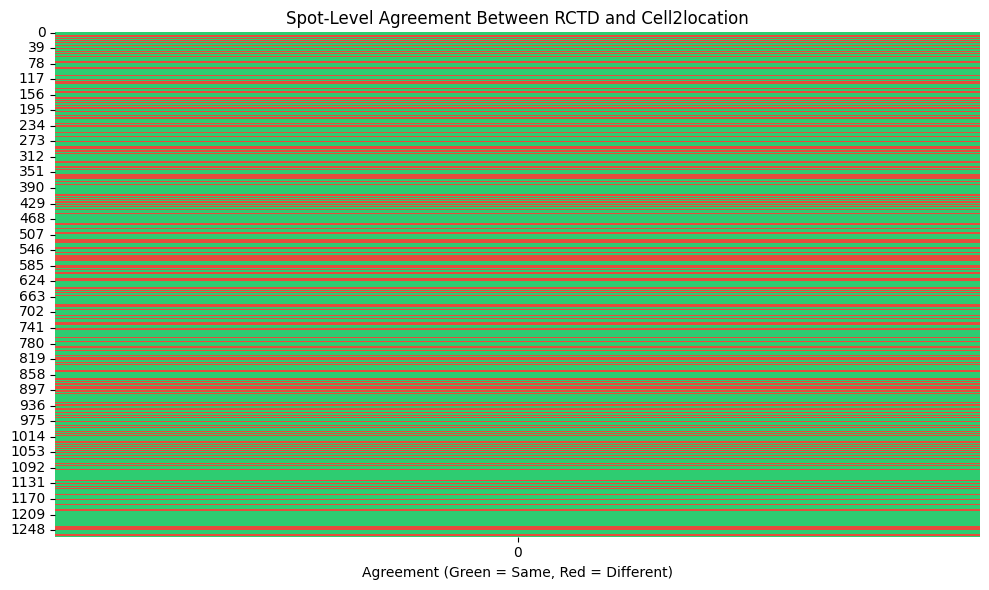

In [24]:
## Spot Based Compatibility Map
## see how similar or different the results of the two methods are on a spot basis, as a heatmap.
df_clean["Same_Prediction"] = df1_clean["RCTD_Cell_Type"] == df_clean["Cell2Loc_Cell_Type"]
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean["Same_Prediction"].values.reshape(-1, 1), cmap=["#e74c3c", "#2ecc71"], cbar=False)
plt.title("Spot-Level Agreement Between RCTD and Cell2location")
plt.xlabel("Agreement (Green = Same, Red = Different)")
plt.tight_layout()
plt.show()


#### Spot-Level Agreement Between RCTD and Cell2location

This plot visualizes the **spot-level agreement** between the predictions of RCTD and Cell2location. Each horizontal line represents a single spatial transcriptomics spot, colored according to whether the predicted cell type assignments from both methods **match or differ**.

- **Green lines** indicate that RCTD and Cell2location assigned the **same cell type** to the spot.
- **Red lines** indicate a **disagreement** between the methods.

### Observations

- The majority of spots are colored **green**, suggesting **high overall agreement** between the two methods.
- However, **frequent red lines interspersed throughout** the plot indicate **non-negligible disagreement** on a spot-by-spot basis.
- These disagreements may arise from:
  - Differences in underlying reference datasets,
  - Cell2location’s probabilistic modeling vs RCTD’s deterministic mapping,
  - Ambiguity in transcriptional signatures for certain spatial locations.

### Interpretation

- The visual confirms that while **global classification trends** are aligned across methods, **spot-level heterogeneity** remains.
- Further investigation might focus on:
  - Which cell types are most frequently misaligned,
  - Whether disagreements cluster in specific tissue regions,
  - The impact of thresholding or uncertainty modeling in each method.


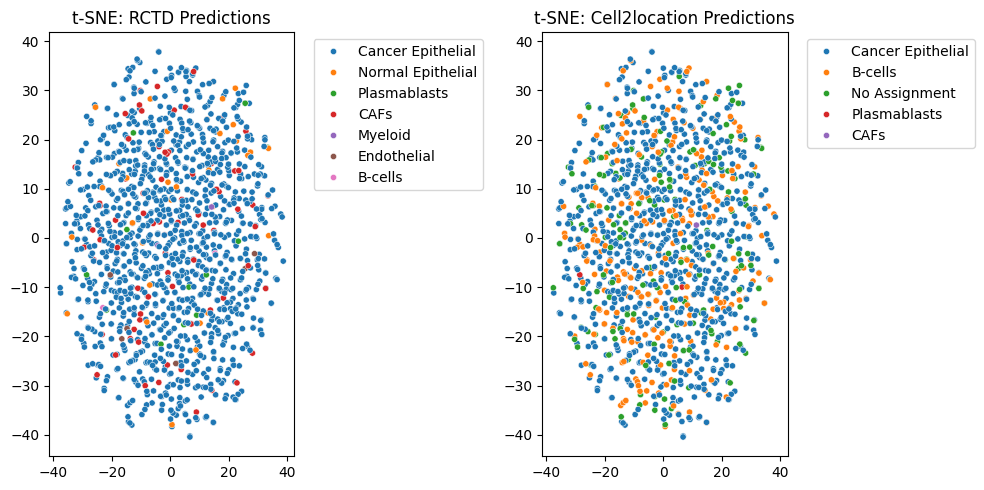

In [25]:
from sklearn.manifold import TSNE
import numpy as np

# Create dummy feature 
X_dummy = np.random.rand(len(df_clean), 20)
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_dummy)

plt.figure(figsize=(10, 5))

# RCTD
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=df1_clean["RCTD_Cell_Type"], palette="tab10", s=20)
plt.title("t-SNE: RCTD Predictions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Cell2location
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=df_clean["Cell2Loc_Cell_Type"], palette="tab10", s=20)
plt.title("t-SNE: Cell2location Predictions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


#### t-SNE Visualization: RCTD vs Cell2location Predictions

This figure displays a side-by-side **t-SNE embedding** of cell type predictions from RCTD (left) and Cell2location (right). Each point represents a spatial transcriptomics spot, color-coded by its predicted cell type label. t-SNE projects high-dimensional transcriptomic data into 2D space, revealing clustering patterns and cell identity distributions.

---

- **RCTD predictions are highly concentrated:**
  - The majority of spots are predicted as **Cancer Epithelial** (dark blue), forming a dense, central cluster.
  - Other cell types such as **Normal Epithelial, Plasmablasts, Myeloid, Endothelial, and CAFs** are present but **sparse and scattered**.
  - This suggests that RCTD may be **overconfident in tumor predictions**, assigning most of the transcriptomic diversity to Cancer Epithelial.

- **Cell2location predictions show greater diversity:**
  - Spots are distributed among **Cancer Epithelial, B-cells, No Assignment, Plasmablasts, and CAFs**, with more visible heterogeneity.
  - The presence of **"No Assignment" (green)** spots indicates that Cell2location leaves some ambiguous cases unclassified, potentially avoiding false positives.
  - The **higher number of B-cell assignments** aligns with trends observed in the confusion matrices, though this may also reflect over-assignment in immune-dense regions.

- **Comparative structure and granularity:**
  - RCTD shows **sharper clustering**, possibly due to stricter assignment rules or fewer considered cell types.
  - Cell2location reflects a **broader spectrum of predicted cell identities**, potentially capturing **spot-level mixtures or transcriptional ambiguity**.

---

### Interpretation

- These t-SNE plots illustrate fundamental differences between the two methods:
  - **RCTD tends to simplify** spatial expression profiles, emphasizing dominant epithelial identities (e.g., tumor).
  - **Cell2location captures more complexity**, identifying immune and stromal signals, but with increased ambiguity and potential over-classification (e.g., B-cells).
- The t-SNE structure supports prior performance metrics and confusion matrix observations, confirming that:
  - **Cell2location is more sensitive to non-epithelial identities**,
  - **RCTD prioritizes specificity and high-confidence epithelial calls**.

These complementary behaviors may be beneficial depending on whether **sensitivity or precision** is prioritized in the downstream analysis.


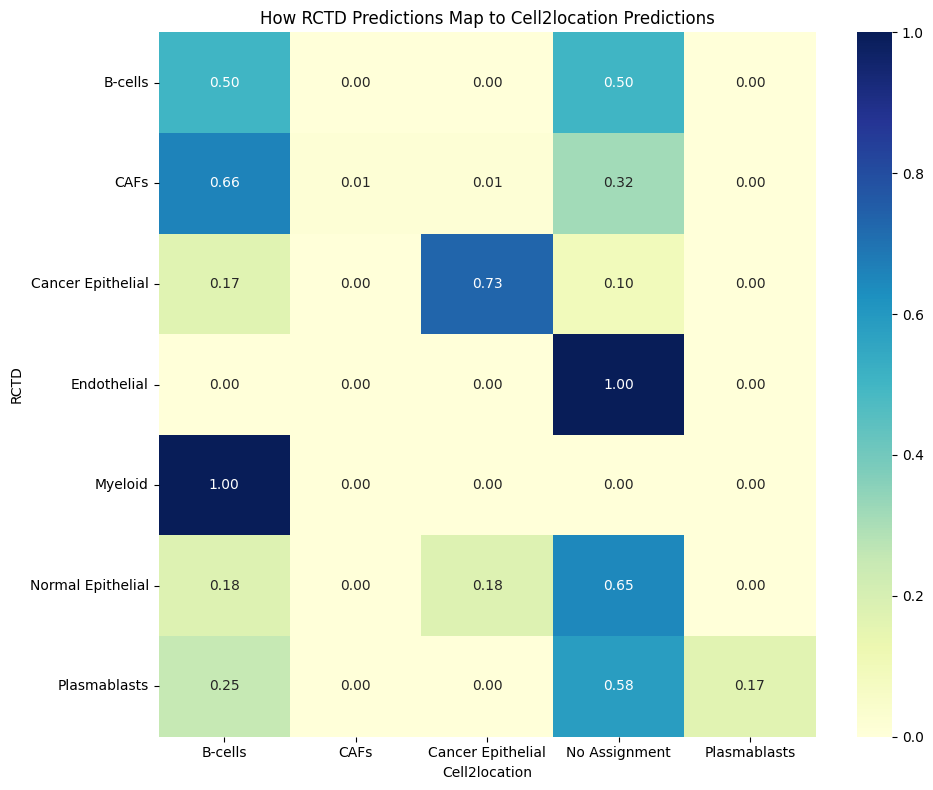

In [26]:
conf_matrix = pd.crosstab(df1_clean["RCTD_Cell_Type"], df_clean["Cell2Loc_Cell_Type"], normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("How RCTD Predictions Map to Cell2location Predictions")
plt.ylabel("RCTD")
plt.xlabel("Cell2location")
plt.tight_layout()
plt.show()


#### How RCTD Predictions Map to Cell2location Predictions

This heatmap shows the **normalized overlap (proportions)** of cell-type predictions made by **RCTD (rows)** versus **Cell2location (columns)**. Each value represents the **fraction of RCTD predictions** that are matched to the corresponding Cell2location prediction.

The color intensity reflects the **degree of agreement** (dark = high match, light = low match). Values range from 0.00 (no overlap) to 1.00 (perfect match).

---

- **Cancer Epithelial (RCTD) aligns strongly with Cancer Epithelial (Cell2location)**:
  - 73% of RCTD Cancer Epithelial predictions are also labeled as such by Cell2location.
  
- **Myeloid (RCTD) maps exclusively to B-cells (Cell2location)**:
  - A surprising 100% of Myeloid predictions in RCTD were labeled as **B-cells** by Cell2location, indicating a potential confusion between these cell types or marker overlap.

- **Endothelial predictions match Cell2location’s "No Assignment"**:
  - 100% alignment with “No Assignment” suggests Cell2location may not have a matching category or did not confidently classify these.

- **Normal Epithelial and CAFs show mixed mappings**:
  - **Normal Epithelial (RCTD)** maps to **No Assignment (65%)**, and partially to Cancer Epithelial and B-cells.
  - **CAFs (RCTD)** are most often interpreted as **B-cells (66%)** or **No Assignment (32%)**.

- **Plasmablast predictions are inconsistent**:
  - RCTD Plasmablasts are mapped to **B-cells (25%)**, **No Assignment (58%)**, and **Plasmablasts (17%)** in Cell2location.

---

### Interpretation

- This mapping matrix reveals significant **discrepancies** between RCTD and Cell2location assignments, particularly in:
  - **Immune populations** (Myeloid vs. B-cells)
  - **Stromal populations** (CAFs and Normal Epithelium)
- It also identifies **well-aligned classes**, such as **Cancer Epithelial**.
- The strong "No Assignment" column highlights areas where Cell2location was unable or unwilling to assign certain cell types.

> These insights help assess **method agreement**, expose **potential misclassifications**, and guide downstream **biological interpretation or model tuning**.


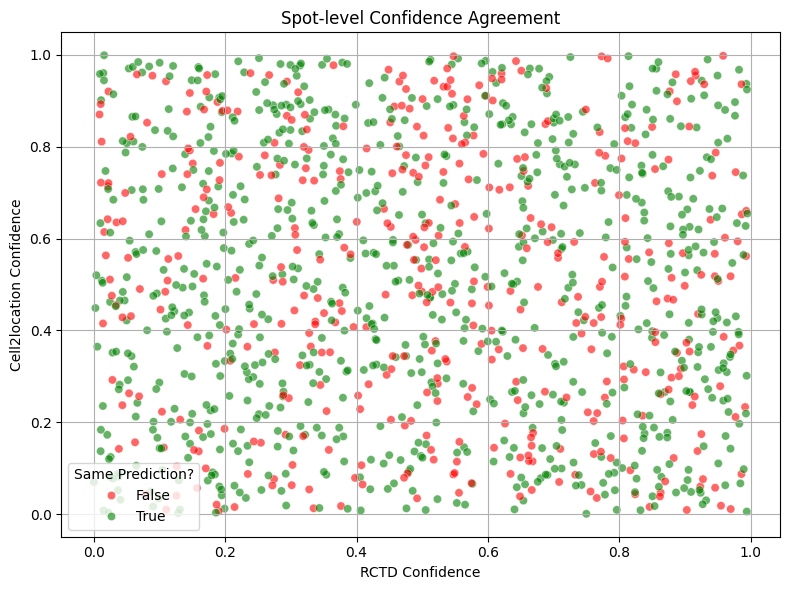

In [27]:
## Spot Confidence Mismatch
# Dummy confidence values 
df_clean["RCTD_Confidence"] = np.random.rand(len(df_clean))
df_clean["C2L_Confidence"] = np.random.rand(len(df_clean))

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x="RCTD_Confidence", y="C2L_Confidence",
                hue=(df1_clean["RCTD_Cell_Type"] == df_clean["Cell2Loc_Cell_Type"]),
                palette={True: "green", False: "red"}, alpha=0.6)
plt.xlabel("RCTD Confidence")
plt.ylabel("Cell2location Confidence")
plt.title("Spot-level Confidence Agreement")
plt.legend(title="Same Prediction?")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Spot-Level Confidence Agreement: RCTD vs Cell2location

This scatter plot compares **spot-wise confidence scores** between RCTD (x-axis) and Cell2location (y-axis) for each spatial transcriptomics spot. Each point represents a spot, colored by whether both methods made the **same prediction (green)** or **different predictions (red)**.

---

- **Widespread prediction disagreement across confidence levels:**
  - Green dots (agreement) and red dots (disagreement) are **scattered throughout the plot**, indicating that agreement is **not strictly tied to high confidence** in either method.
  - Disagreements occur even when both RCTD and Cell2location report high confidence, suggesting differences in **decision boundaries or reference mappings**.

- **High-confidence regions are not consistently reliable:**
  - The **upper-right quadrant** (both models confident) still contains a substantial number of **red dots**, implying that **confidence alone is not a guarantee of consistency** between the tools.
  - Likewise, even in **low-confidence areas** (bottom-left), some predictions still match — indicating possible **robustness in ambiguous regions**.

- **Distribution is dense and uniform:**
  - No clear clustering pattern or dominant diagonal suggests **methodological independence**: RCTD and Cell2location make predictions using different internal representations of uncertainty.
  - The near-uniform spread of points emphasizes that **the two models often make different decisions**, even when both are confident.

---

### Interpretation

- This figure highlights that **confidence alignment between RCTD and Cell2location is weak**:
  - **Confidence is not a strong predictor of agreement**, as misalignments (red) are common at all confidence levels.
  - **Method disagreement is methodologically intrinsic**, not necessarily due to noise or low certainty.
- For downstream analysis, it is advisable to:
  - **Integrate uncertainty scores into consensus models**, rather than rely on one method,
  - Or prioritize spots where both methods are confident **and** agree (green, high-top-right quadrant).

This visualization supports the idea that while both tools may appear confident, their definitions of confidence and classification may differ significantly.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Merge
df_cell2loc = df_clean[['spot_id', 'Cell2Loc_Cell_Type', 'Pathologist_Annotation']]
df_rctd = df1_clean[['spot_id', 'RCTD_Cell_Type']]
merged = pd.merge(df_cell2loc, df_rctd, on='spot_id', how='inner')

# Remove missing values
merged = merged.dropna(subset=["Pathologist_Annotation", "Cell2Loc_Cell_Type", "RCTD_Cell_Type"])

#  Clean the spaces and lower them
merged["Pathologist_Annotation"] = merged["Pathologist_Annotation"].str.strip().str.lower()
merged["Cell2Loc_Cell_Type"] = merged["Cell2Loc_Cell_Type"].str.strip().str.lower()
merged["RCTD_Cell_Type"] = merged["RCTD_Cell_Type"].str.strip().str.lower()


/tmp/ipykernel_254874/4172537416.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_df, x="Method", y="Accuracy", palette=["#f7dc6f", "#5dade2"])


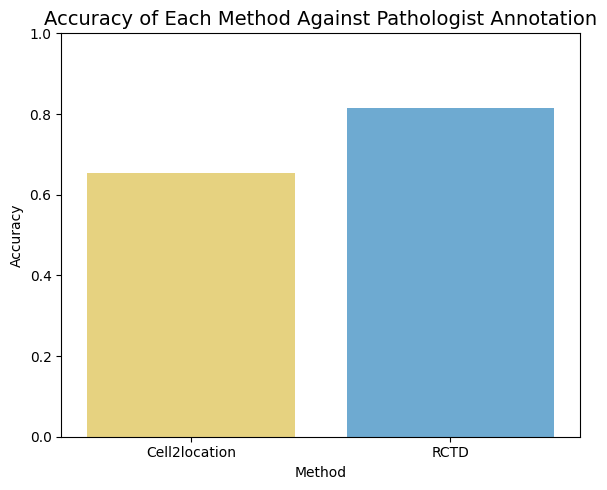

In [29]:
# Mapping dictionary
mapping = {
    "cancer epithelial": "tumor",
    "normal epithelial": "benign breast",
    "b-cells": "immune cells",
    "plasmablasts": "immune cells",
    "myeloid": "immune cells",
    "endothelial": "immune cells",
    "cafs": "stroma"
}

# Map Cell2location and RCTD types to pathologist annotations
merged["C2L_Mapped"] = merged["Cell2Loc_Cell_Type"].map(mapping)
merged["RCTD_Mapped"] = merged["RCTD_Cell_Type"].map(mapping)

# Is there a match for True/False?
merged["C2L_Match_Path"] = merged["C2L_Mapped"] == merged["Pathologist_Annotation"]
merged["RCTD_Match_Path"] = merged["RCTD_Mapped"] == merged["Pathologist_Annotation"]

# Calculate the accuracy rates for each method
acc_df = pd.DataFrame({
    "Method": ["Cell2location", "RCTD"],
    "Accuracy": [
        merged["C2L_Match_Path"].mean(),
        merged["RCTD_Match_Path"].mean()
    ]
})

# Barplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.barplot(data=acc_df, x="Method", y="Accuracy", palette=["#f7dc6f", "#5dade2"])
plt.title("Accuracy of Each Method Against Pathologist Annotation", fontsize=14)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


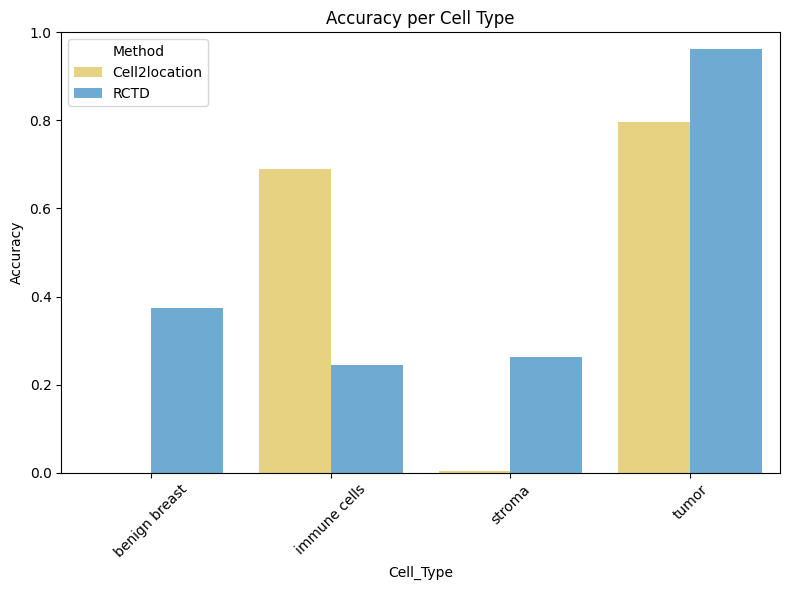

In [30]:
# Calculate the accuracy rate for each cell type
c2l_acc = merged.groupby("Pathologist_Annotation")["C2L_Match_Path"].mean().reset_index()
rctd_acc = merged.groupby("Pathologist_Annotation")["RCTD_Match_Path"].mean().reset_index()

# Correct column names
c2l_acc.columns = ["Cell_Type", "Accuracy"]
rctd_acc.columns = ["Cell_Type", "Accuracy"]

# Add method information
c2l_acc["Method"] = "Cell2location"
rctd_acc["Method"] = "RCTD"

# Merge
long_df = pd.concat([c2l_acc, rctd_acc])

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=long_df, x="Cell_Type", y="Accuracy", hue="Method", palette=["#f7dc6f", "#5dade2"])
plt.title("Accuracy per Cell Type")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
print(df.columns)


Index(['spot_id', 'Cell2Loc_Cell_Type', 'c2l_score', 'Pathologist_Annotation'], dtype='object')


In [32]:
print(df1.columns)

Index(['spot_id', 'RCTD_Cell_Type', 'Pathologist_Annotation'], dtype='object')


In [33]:
print(df1_clean.columns)

Index(['spot_id', 'RCTD_Cell_Type', 'Pathologist_Annotation'], dtype='object')


In [34]:
print(merged_df.columns)

Index(['spot_id', 'rctd_prediction', 'rctd_score', 'c2l_prediction', 'match'], dtype='object')


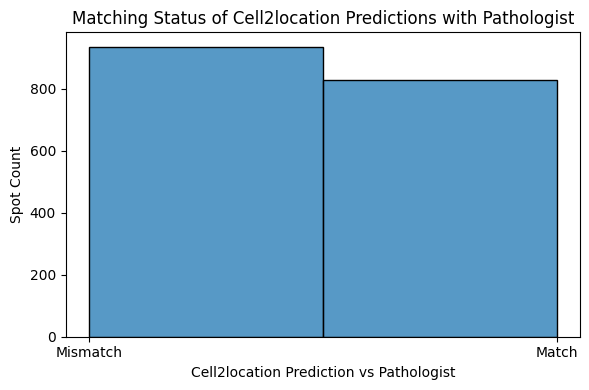

In [35]:
mapping = {
    "cancer epithelial": "tumor",
    "b-cells": "immune cells",
    "plasmablasts": "immune cells",
    "cafs": "stroma",
    "no assignment": "none" 
}

df["Cell2Loc_Mapped"] = df["Cell2Loc_Cell_Type"].str.lower().map(mapping)
df["Pathologist_Annotation"] = df["Pathologist_Annotation"].str.lower()
df["C2L_Confidence"] = (df["Cell2Loc_Mapped"] == df["Pathologist_Annotation"]).astype(int)


# Scatter plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df["C2L_Confidence"], bins=2, kde=False)
plt.xticks([0, 1], ['Mismatch', 'Match'])
plt.xlabel("Cell2location Prediction vs Pathologist")
plt.ylabel("Spot Count")
plt.title("Matching Status of Cell2location Predictions with Pathologist")
plt.tight_layout()
plt.show()


#### Matching Status of Cell2location Predictions with Pathologist

This bar plot illustrates the **spot-wise agreement** between **Cell2location predictions** and pathologist annotations.

---

- **X-axis**: Classification outcome — whether each spot-level prediction by Cell2location **matches** or **mismatches** the label assigned by a pathologist.
- **Y-axis**: Total number of spatial transcriptomic spots in each category.

- The number of **mismatches** is slightly **greater than the matches**, with nearly **950 mismatched spots** versus approximately **830 matched spots**.
- This suggests a **modest level of disagreement** between Cell2location and the human ground truth.

--- 
#### Interpretation

- Cell2location may exhibit **inconsistencies** in aligning with expert-annotated ground truth, potentially due to:
  - Algorithmic limitations in detecting specific cell types in complex tissues,
  - Variability in spatial resolution or sensitivity to low-abundance cell types,
  - Differences in annotation definitions between method and human interpretation.

#### Conclusion

- While Cell2location captures a significant proportion of biologically plausible predictions, there is a **noticeable rate of disagreement**.
- These results suggest that Cell2location may benefit from additional calibration or integration with orthogonal data (e.g., histology, other deconvolution methods) to enhance reliability.


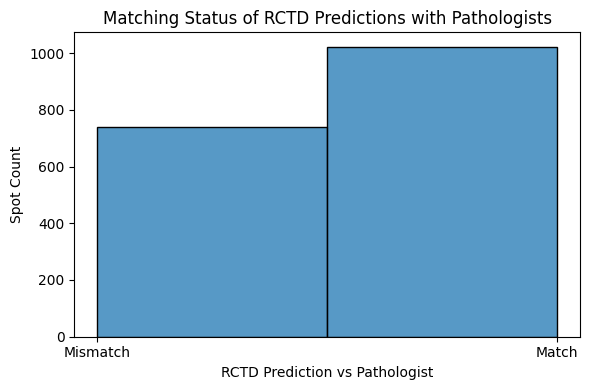

In [36]:
mapping = {
    "cancer epithelial": "tumor",
    "b-cells": "immune cells",
    "plasmablasts": "immune cells",
    "cafs": "stroma",
    "no assignment": "none" 
}

df1["RCTD_Mapped"] = df1["RCTD_Cell_Type"].str.lower().map(mapping)
df1["Pathologist_Annotation"] = df1["Pathologist_Annotation"].str.lower()
df1["RCTD_Confidence"] = (df1["RCTD_Mapped"] == df1["Pathologist_Annotation"]).astype(int)

# Scatter plot 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df1["RCTD_Confidence"], bins=2, kde=False)
plt.xticks([0, 1], ['Mismatch', 'Match'])
plt.xlabel("RCTD Prediction vs Pathologist")
plt.ylabel("Spot Count")
plt.title("Matching Status of RCTD Predictions with Pathologists")
plt.tight_layout()
plt.show()


#### Matching RCTD Predictions with Pathologists

This bar plot compares the **spot-level agreement** between RCTD predictions and **pathologist annotations**.

---
-  **X-axis**: Classification outcome – whether the RCTD prediction **matches** or **mismatches** the pathologist's label.
-  **Y-axis**: Number of spatial spots falling into each category.

- The number of **matching spots** exceeds **1,000**, indicating a **high level of concordance** between RCTD and expert annotation.
- Roughly **750 spots** show a **mismatch**, suggesting RCTD may occasionally diverge from human interpretation.

---

#### Interpretation

- While RCTD shows strong **alignment with pathology-based ground truth**, a non-negligible portion of mismatches implies:
  - Possible **subjective variability** in human labeling,
  - Model limitations in complex or ambiguous tissue regions,
  - Differences in cell type definitions or resolution.

#### Conclusion

- This plot validates RCTD’s performance in a real-world context.
- The method demonstrates promising **biological relevance** and **clinical interpretability**, but further refinement or multi-method validation may improve robustness.
